## Домашнее задание

Откуда берутся датасеты? Практический проект по сбору данных и работе с текстами

Цель:

В этом домашнем задании вам предстоит обойти все ловушки серверов, пробраться сквозь страницы html-код, собрать себе свой собственный датасет и натренировать на нём модель.

##    Часть 2. NLP.

1. Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
2. Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.
3. Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.
4. Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.
5. Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов). Проинтерпретируйте результаты.

   
P.S. Если с парсингом не задалось или данных собралось слишком мало - не отчаивайтесь, главное, что ваш парсер собрал хоть что-то! А для второй части задания можно скачать данные по отзывам на фильмы с сайта IMDB (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews), в которых для каждого отзыва поставлена семантическая оценка - "позитивный" или "негативный".

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import LancasterStemmer,WordNetLemmatizer

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from wordcloud import WordCloud

In [2]:
df_imdb = pd.read_csv('data/IMDB_Dataset.csv')

In [3]:
df_imdb.shape

(50000, 2)

In [4]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df_imdb.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [6]:
#df_imdb['sentiment'].value_counts()
df_imdb.groupby(['sentiment']).count()

,review
sentiment,
negative,25000
positive,25000


In [7]:
## посмотрим на случайно выбранный отзыв
num = np.random.randint(0, 49999, 1)
review = df_imdb.review[num[0]]
sentiment = df_imdb.sentiment[num[0]]

print(f'ID: {num} \n')
print(f'Review: {review} \n')
print(f'Sentiment: {sentiment}')

ID: [24729] 

Review: While Fred Schepisi's "I.Q." doesn't really have any important qualities, it's still worth seeing. Walter Matthau plays Albert Einstein, trying to help mechanic Ed Walters (Tim Robbins) fall in love with Princeton mathematics doctoral candidate Catherine Boyd (Meg Ryan). Probably the funniest scene is when Dr. Frizzyhead and friends (Lou Jacobi, Gene Saks and Joseph Maher) try to make Ed look like a scientist: he ends up looking like a French impressionist.<br /><br />Obviously little of the movie is historically accurate, but that's not the point. It's not intended as anything except a light comedy, quite the opposite of Robbins's most famous movie from 1994 (The Shawshank Redemption). A movie about Einstein's whole life would have to focus not only on his scientific achievements, but also his political activism, namely how he wrote a letter on behalf of the Scottsboro Nine and came out against nuclear weapons (it got to the point where the FBI kept a file on him

Поскольку целевая переменная закодирована словами, необходимо привести ее к числовому виду

In [8]:
# Функция для кодирования лейблов
def label2num(y):
    if y == 'positive':
        return 1
    if y == 'negative':
        return 0

In [9]:
df_imdb['sentiment'] = df_imdb['sentiment'].apply(label2num)

In [10]:
df_imdb['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

## Предобработка текста

### Шаг 1. Токенизация

Инициализируем WordPunctTokenizer, с помощью которого затем разобьем текст на слова.

In [11]:
word_tokenizer = nltk.WordPunctTokenizer() # знаки препинания (группами) идут в один токен
tokens = word_tokenizer.tokenize('we will, we will rock you!!!!')
print(tokens)

['we', 'will', ',', 'we', 'will', 'rock', 'you', '!!!!']


Удалим специальные символы и переведем текст в нижний регистр 

In [12]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    if remove_digits:
        pattern=r'[^a-zA-z\s]'
    else:
        pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text.lower()

In [13]:
#Apply function on review column
df_imdb['review']=df_imdb['review'].apply(remove_special_characters)

### Шаг 2. Удаление стоп-слов

In [14]:
# загружаем список стоп-слов пакета nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vlad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
stopword_list = nltk.corpus.stopwords.words('english')

# примеры стоп-слов
print(len(stopword_list))
print(stopword_list[:10])

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [16]:
#removing the stopwords
def remove_stopwords(text):
    tokens = word_tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    

    return filtered_text

In [17]:
#Apply function on review column
df_imdb['review']=df_imdb['review'].apply(remove_stopwords)

### Шаг 3. Нормализация слов

In [18]:
#Stemming the text
def simple_stemmer(text):
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    #ps=nltk.porter.PorterStemmer()
    text= ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [19]:
#Apply function on review column
df_imdb['review']=df_imdb['review'].apply(simple_stemmer)

In [20]:
## посмотрим на случайно выбранный отзыв по итогам проведенной предобработки 
num = np.random.randint(0, 49999, 1)
review = df_imdb.review[num[0]]
sentiment = df_imdb.sentiment[num[0]]

print(f'ID: {num} \n')
print(f'Review: {review} \n')
print(f'Sentiment: {sentiment}')

ID: [19717] 

Review: among one mani usa attempt remak old classic british tv show that famous one see none havent mention even acknowledg knew tv ss call secret agent man origin secret agent man star great patrick mcgoohan prisonerbraveheartic station zebrath phantom etc man tap first jame bond turn mcgoohan devout man consid jame bond bed hop violent way valuesbr br show done black white piti havent seen ityou miss lot charact mr mcgoohan play secret agent man name drake finish show went popular though time bizarr controversi tv seri call prison charact play prison agent whos ident reveal kidnap transport island know respons kidnap know captor want know reason behind resign british secret servic island populac dont name refer number patrick charact assign number argu prison charact fact charact play secret agent man mcgoohan disput thisbr br ofours unmistak famous theme song origin secret agent man spawn written johnni river famous pop musician read actual think song come version sho

Видим, что специальные символы и стоп-слова удалены, текст нормализован и можем переходить к построению модели

## Разделим данные на train и test

In [21]:
data = df_imdb['review']
labels = df_imdb['sentiment']

In [22]:
data.shape, labels.shape

((50000,), (50000,))

In [23]:
#X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=13)
train_texts, test_texts, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=13)

In [24]:
train_texts.shape, test_texts.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

In [25]:
train_texts[0]

'one review mention watch oz episod youll hook right exact happen mebr br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may bec

In [26]:
y_train[0]

1

## Построение модели

In [27]:
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, use_idf=True, ngram_range=(1,3))
vectorizer.fit(train_texts)

TfidfVectorizer(min_df=0.0, ngram_range=(1, 3))

In [28]:
# Обучаем TF-IDF на train, а затем применяем к train и test
X_train = vectorizer.fit_transform(train_texts)
X_test  = vectorizer.transform(test_texts)

In [29]:
print('Tfidf_train:', X_train.shape)
print('Tfidf_test:', X_test.shape)

Tfidf_train: (40000, 6760690)
Tfidf_test: (10000, 6760690)


### Обучаем классификатор

In [30]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=13)

#Fitting the model for tfidf features
lr.fit(X_train,y_train)
print(lr)

LogisticRegression(C=1, max_iter=500, random_state=13)


In [31]:
##Predicting the model for tfidf features
y_pred=lr.predict(X_test)
print(y_pred)

[0 0 1 ... 1 0 0]


In [32]:
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(y_test,y_pred)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.8848


In [33]:
#Classification report for tfidf features
lr_tfidf_report=classification_report(y_test,y_pred,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.90      0.87      0.88      5058
    Negative       0.87      0.90      0.88      4942

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



Визуализируем позитивные и негативные слова с использованием пакета Word Cloud

Позитивное ревью

<function matplotlib.pyplot.show(close=None, block=None)>

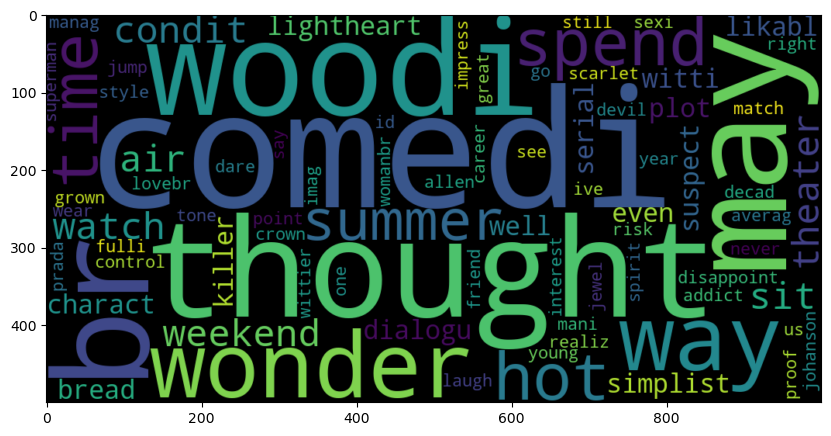

In [34]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=train_texts[2]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

Негативное ревью

<function matplotlib.pyplot.show(close=None, block=None)>

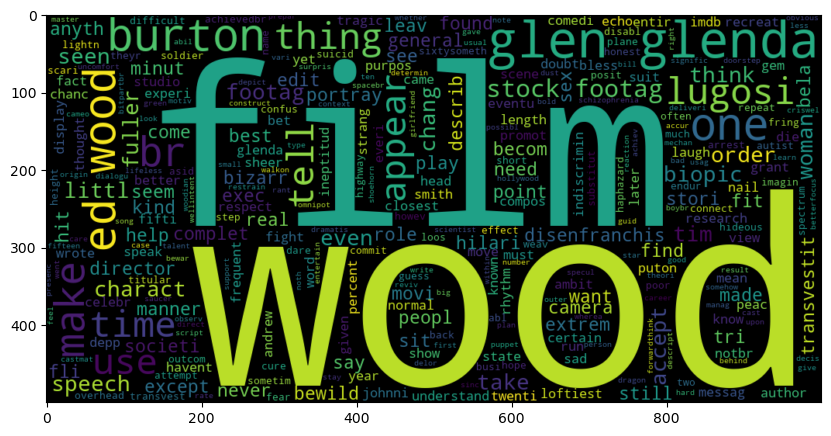

In [35]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=train_texts[44200]  ## 30790, 44200
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

## Вывод

По итогам проведенной предобработки текста отзывов
- удаления специальных символов;
- удаления стоп-слов;
- стемминга;
  
даже простая модель логистической регрессии показала очень хороший результат в задаче анализа тональности: f1-score = 0.88